<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Chapter-3d:-Decision-tree-ensembles-for-geodata-time-series-regression" data-toc-modified-id="Chapter-3d:-Decision-tree-ensembles-for-geodata-time-series-regression-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Chapter 3d: Decision tree ensembles for geodata time series regression</a></span><ul class="toc-item"><li><span><a href="#1.-Data-exploration" data-toc-modified-id="1.-Data-exploration-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>1. Data exploration</a></span><ul class="toc-item"><li><span><a href="#1.1.-Data-loading" data-toc-modified-id="1.1.-Data-loading-1.1.1"><span class="toc-item-num">1.1.1&nbsp;&nbsp;</span>1.1. Data loading</a></span></li></ul></li><li><span><a href="#2.-Random-forest-baseline-model" data-toc-modified-id="2.-Random-forest-baseline-model-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>2. Random forest baseline model</a></span><ul class="toc-item"><li><span><a href="#2.1.-Feature-engineering" data-toc-modified-id="2.1.-Feature-engineering-1.2.1"><span class="toc-item-num">1.2.1&nbsp;&nbsp;</span>2.1. Feature engineering</a></span></li><li><span><a href="#2.2.-Random-forest-training-&amp;-prediction" data-toc-modified-id="2.2.-Random-forest-training-&amp;-prediction-1.2.2"><span class="toc-item-num">1.2.2&nbsp;&nbsp;</span>2.2. Random forest training &amp; prediction</a></span></li></ul></li><li><span><a href="#Using-AdaBoostRegressor" data-toc-modified-id="Using-AdaBoostRegressor-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Using AdaBoostRegressor</a></span></li><li><span><a href="#Using-LGBMRegressor" data-toc-modified-id="Using-LGBMRegressor-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Using LGBMRegressor</a></span><ul class="toc-item"><li><span><a href="#2.3-References" data-toc-modified-id="2.3-References-1.4.1"><span class="toc-item-num">1.4.1&nbsp;&nbsp;</span>2.3 References</a></span></li></ul></li></ul></li></ul></div>

# Chapter 3d: Decision tree ensembles for geodata time series regression

In the last notebook of chapter 3, we will focus our attention on decision trees for time series regression in order to predict the occurrence time of lab-quakes, or -more precisely- rock failure under load in a laboratory setting. This work will use the data and some of the methods developed in the context of a Kaggle competition that took place in 2019.

The goal of the [LANL Earthquake Prediction Kaggle competition](https://www.kaggle.com/c/LANL-Earthquake-Prediction) was to use seismic signals to predict the timing of "laboratory earthquakes".

The data comes from a well-known experimental set-up used to study earthquake physics. The `acoustic_data` input signal is used to predict the time remaining before the next laboratory earthquake (`time_to_failure`).

The training data is a single, continuous segment of experimental data. Originally, the test data consists of a folder containing many small segments. The data within each test file is continuous, but the test files do not represent a continuous segment of the experiment; thus, the predictions cannot be assumed to follow the same regular pattern seen in the training file. However, since the `time_to_failure` values are not provided alongside the test data (competition setting), we will here only use the "training set" and split it into new training set and test set for model performance analysis.


## 1. Data exploration

### 1.1. Data loading

We will only use the file `train.csv`, a single, continuous training segment of experimental data, consisting of the data field:
* `acoustic_data` - the seismic signal [int16]
* `time_to_failure` - the time (in seconds) until the next laboratory earthquake [float64]

In [1]:
import numpy as np  # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

pd.options.display.precision = 15

**EXERCISE 1:** Download the training data file `train.csv` from the Kaggle competition page. Make sure you have enough space on your machine (2.44 GB zipped, c. 10 GB unzipped). Then run the next cell.

In [2]:
%%time
data = pd.read_csv('D:/MLGeo-Data/train.csv/train.csv', dtype={'acoustic_data': np.int16, 'time_to_failure': np.float32})
data.head()

Wall time: 3min 34s


,acoustic_data,time_to_failure
0,12,1.469099998474121
1,6,1.469099998474121
2,8,1.469099998474121
3,5,1.469099998474121
4,8,1.469099998474121


Let's now plot the data with both acoustic data and time-to-failure on the same x-axis.

**EXERCISE 2:** Run the following code but first define `acoustic_data_lowres` and `time_to_failure_lowres`. As the data is huge, we will only plot the data every 100 rows. _Hint:_ In Python, we can call indices every n steps by using `[::n]`.

/home/andrea/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


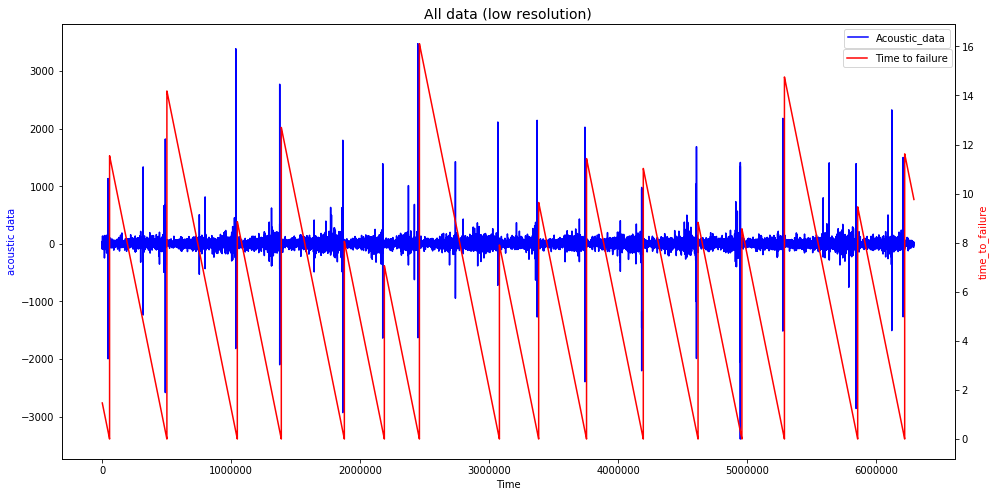

In [4]:
# YOUR CODE HERE
# lower resolution for plotting
acoustic_data_lowres = data.acoustic_data.values[::100]
time_to_failure_lowres = data.time_to_failure.values[::100]

fig, ax1 = plt.subplots(figsize = (16, 8))
plt.title('All data (low resolution)', size = 14)
plt.plot(acoustic_data_lowres,color = 'b')
ax1.set_ylabel('acoustic data', color = 'b')
ax1.set_xlabel('Time')
plt.legend(['Acoustic_data'])
ax2 = ax1.twinx()
plt.plot(time_to_failure_lowres, color = 'r')
ax2.set_ylabel('time_to_failure', color = 'r')
plt.legend(['Time to failure'], loc = (0.875, 0.9));

**EXERCISE 3:** Zoom in by plotting only the first 1% of the data. _Hint:_ In Python, the first n indices can be retrieved using `[:n]`.

/home/andrea/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


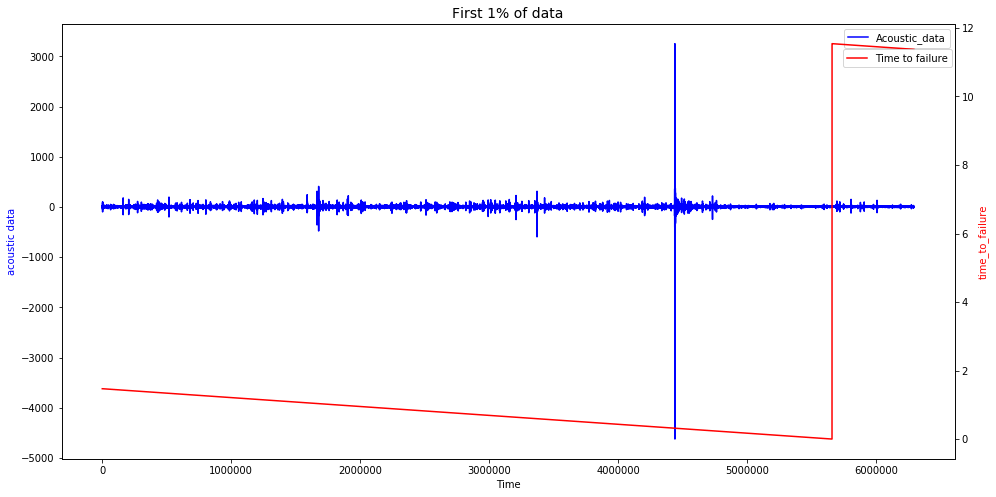

In [6]:
ind=round(len(data)/100)

fig, ax1 = plt.subplots(figsize = (16, 8))
plt.title('First 1% of data', size = 14)
plt.plot(data.acoustic_data[:ind], color = 'b')
ax1.set_ylabel('acoustic data', color = 'b')
ax1.set_xlabel('Time')
plt.legend(['Acoustic_data'])
ax2 = ax1.twinx()
plt.plot(data.time_to_failure[:ind], color = 'r')
ax2.set_ylabel('time_to_failure', color = 'r')
plt.legend(['Time to failure'], loc = (0.875, 0.9));

## 2. Random forest baseline model

We read from the Kaggle competition description: "_The competition builds on initial work from Bertrand Rouet-Leduc, Claudia Hulbert, and Paul Johnson. B. Rouet-Leduc prepared the data for the competition._" (Rouet-Leduc et al., 2017).

In the [introduction](https://www.kaggle.com/c/LANL-Earthquake-Prediction/discussion/77525) of the competition's discussion section, Bertrand Rouet-Leduc gives us more details and links to three additional articles (Rouet-Leduc et al., 2018; 2019; Hulbert et al., 2019). Compared to what has been published, he mentions that, for this Kaggle competition, they selected "_an experiment that exhibits a **very aperiodic** and more realistic behavior compared to the data we studied in our early work, with **earthquakes occurring very irregularly**._" He adds on a second post that "_you will have to build a model that predicts the time remaining before failure from a chunk of seismic data, like we have done in our first paper above on easier data._"

The aim of this section is to attempt to reproduce the original study of Rouet-Leduc et al. (2017). It first requires some important feature engineering.

In [3]:
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score

### 2.1. Feature engineering

Machine learning applications to time series often require to turn the raw data into a collection of features based on various statistical metrics estimated from the distribution of the raw data in fixed time windows.

We learn from Rouet-Leduc et al. (2017:Fig. 1) that "_the RF model predicts the time remaining before the next failure by averaging the predictions of 1,000 decision trees for each time window._" which gives us `n_estimators = 1000`. In Fig. 2, we learn that the RF was trained of c. 150 s of data (c. 10 slip events) and tested on the following c. 150 s. No more details are given in the main text and we have to turn to the supplementary material to get more details about the engineered features and hyperparameters:

At each node, they selected a random subset of 40% of the available features, which gives us `max_features = 0.4`. We learn later on that this value had been selected via 3-fold cross-validation (from a range 30-40%).

As split criterion, they used maximum reduction of empirical variance, which is `criterion = 'mse'` (the default in RandomForestRegressor). No information was given about maximum depth.

The authors used moving time windows of 1.8 s each, with an offset of 0.18 s (i.e. 90% overlap between consecutive windows). Each window corresponds to one observation $X_i$ (feature vector) and label $y_i$ (time remaining until next failure).

Here is the list of features:
- Signal distribution (to capture evolution of signal's energy) = 7 features: **kth-order moment** of acoustic data corresponding to mean, normalized/non-normalized variance, normalized/non-normalized skewness, and normalized/non-normalized kurtosis;
- Precursors (bursts of acoustic emissions) = 18+10+2 = 30 features: **1st-to-9th and 91th-to-99th percentiles** (per 1% increment), the fraction of times the strain is greater than **thresholds f_0 derived from signal processing** with **f_0 = 1e-9, 5e-9, 1e-8, 5.e-8 and 1e-7** and the fraction of times it is lower than their negatives -f_0, and finally **min/max** values;
- Time correlation = 5 features: **Fourier transforms** on frequency bands {(19.65, 20.65), (39.8, 40.8), (80.1, 81.1)} in kHz, the **autocorrelation** and the **partial autocorrelation**. Regarding those last 5 features, the authors mentioned "_These features that we initially thought would be critical, are deemed to be of very low importance by the random forest models we built_".

Features were originally defined from the raw data and the **first finite difference of the data**. The authors found that the RF had a **slight performance advantage when only using the derivative signal**.

We verify that we get (7+30+5) times 2 = **84 features**. The doubling comes from a **window split**, which gave the algorithm a notion of **short-term evolution of the signal**. It means that the 42 features were estimated twice for the two subwindows of each "observation". You will try to construct your features based on this information, which is the core work of this notebook.

In [4]:
# define samples composed of n_records
n_records = 150000
n_data=len(data)
n_segments = int(n_data / n_records)
n_segments

4194

**EXERCISE 4:** Initiate the `X` data frame with feature names using `X = pd.DataFrame(index = range(N_SAMPLES), columns = ['COLUMN_NAME1', 'COLUMN_NAME2', ...])`. In a first step, define the 7 signal distribution features, as described above. You should thus define 14 features since you define those features for two time windows. _Hint:_ use e.g. `meanA` for the mean of first half of segment length, `meanB` for the second half, `varA` for variance of first half, etc. In future exercises, you will comment your `X` and define larger sets of features, then reiterate all the following cells to improve the model performance. Always comment your old feature sets (for grading purposes).

In [5]:
y = pd.DataFrame(index = range(n_segments), columns = ['time_to_failure'])

X = pd.DataFrame(index = range(n_segments))

**EXERCISE 5:** Compute the features for all segment samples by using the following template. To help you, the `mean` feature is already defined for the 2 time windows.

In [7]:
test=data[round(n_records/2)+1:n_records]#['acoustic_data']

75001     False
75002     False
75003     False
75004     False
75005     False
          ...  
149995    False
149996    False
149997    False
149998    False
149999    False
Name: acoustic_data, Length: 74999, dtype: bool

In [13]:
test['acoustic_data'][(test['acoustic_data'])/n_data>=1e-7]

Series([], Name: acoustic_data, dtype: int16)

In [14]:
# YOUR CODE HERE
#...
for i in range(n_segments):
    if i % 100 == 0:
        print(i)
    
    segment = data.iloc[i*n_records : i*n_records + n_records]
    y.loc[i, 'time_to_failure']=segment['time_to_failure'].values[-1]
    
    segA=segment.iloc[0:round(n_records/2)]
    segB = segment.iloc[round(n_records/2)+1:n_records]
    
    
    varA=segA['acoustic_data'].var()
    varB=segB['acoustic_data'].var()
    skewA=segA['acoustic_data'].skew()
    skewB=segB['acoustic_data'].skew()
    kurtA=segA['acoustic_data'].kurtosis()
    kurtB=segB['acoustic_data'].kurtosis()
    
    #Non-normalized========================================
    X.loc[i, 'meanA'] = segA['acoustic_data'].mean()
    X.loc[i, 'varA']  = varA
    X.loc[i, 'skewA'] = skewA
    X.loc[i, 'kurtA'] = kurtA
    
    X.loc[i, 'meanB'] = segB['acoustic_data'].mean()
    X.loc[i, 'varB']  = varB
    X.loc[i, 'skewB'] = skewB
    X.loc[i, 'kurtB'] = kurtB
   
    #Normalized=============================================
    X.loc[i, 'varAnorm']  = varA/(varA+varB)
    X.loc[i, 'skewAnorm'] = skewA/(skewA+skewB)
    X.loc[i, 'kurtAnorm'] = kurtA/(kurtA+kurtB)
    
    X.loc[i, 'varBnorm']  = varB/(varA+varB)
    X.loc[i, 'skewBnorm'] = skewB/(skewA+skewB)
    X.loc[i, 'kurtBnorm'] = kurtB/(kurtA+kurtB)
    
    #Percentiles======================================
    for m in range(1,10):
        X.loc[i, 'q0%sA'%str(m)] = np.percentile(segA['acoustic_data'],m)
        X.loc[i, 'q0%sB'%str(m)] = np.percentile(segB['acoustic_data'],m)
    for n in range(91,100):
        X.loc[i, 'q%sA'%str(n)] = np.percentile(segA['acoustic_data'],n)
        X.loc[i, 'q%sB'%str(n)] = np.percentile(segB['acoustic_data'],n)
    
    #Threshold&MaxMin===================================
    
    X.loc[i, 'maxA']  = segA['acoustic_data'].max()
    X.loc[i, 'maxB']  = segB['acoustic_data'].max()
    X.loc[i, 'minA']  = segA['acoustic_data'].min()
    X.loc[i, 'minB']  = segB['acoustic_data'].min()
    
    features,threshold=['f01','f02','f03','f04','f05'],[1e-9,5e-9, 1e-8, 5e-8, 1e-7]
    for feature,k in zip(features,threshold):
        X.loc[i,feature+'A'] = sum(segA['time_to_failure'][(segA['acoustic_data']/n_data)>=k])
        X.loc[i,feature+'B'] = sum(segB['time_to_failure'][(segB['acoustic_data']/n_data)>=k])
        X.loc[i,feature+'A'] = sum(segA['time_to_failure'][(segA['acoustic_data']/n_data)<=-k])
        X.loc[i,feature+'B'] = sum(segB['time_to_failure'][(segB['acoustic_data']/n_data)<=-k])

    '''
    
    #RollingMean=============================================
    
    froll,windows=['r10','r100','r1000'],[10,100,1000]
    for froll,wind in zip(froll,windows):
        segA_rolling_mean = segA['acoustic_data'].rolling(window=wind, win_type='cosine').mean().dropna()
        segA_rolling_std = segA['acoustic_data'].rolling(window=wind, win_type='cosine').std().dropna()
        
        X.loc[i,froll+'_std_max'+'A'] = segA_rolling_std.max() 
        X.loc[i,froll+'_std_min'+'A'] = segA_rolling_std.min() 
        X.loc[i,froll+'_std_mean'+'A'] = segA_rolling_std.mean() 
        X.loc[i,froll+'_std_q01'+'A'] = np.percentile(segA_rolling_std,1)
        X.loc[i,froll+'_std_q05'+'A'] = np.percentile(segA_rolling_std,5)
        X.loc[i,froll+'_std_q95'+'A'] = np.percentile(segA_rolling_std,95)
        X.loc[i,froll+'_std_q99'+'A'] = np.percentile(segA_rolling_std,99)
        
        X.loc[i,froll+'_mean_max'+'A'] = segA_rolling_mean.max() 
        X.loc[i,froll+'_mean_min'+'A'] = segA_rolling_mean.min() 
        X.loc[i,froll+'_mean_mean'+'A'] = segA_rolling_mean.mean() 
        X.loc[i,froll+'_mean_q01'+'A'] = np.percentile(segA_rolling_mean,1)
        X.loc[i,froll+'_mean_q05'+'A'] = np.percentile(segA_rolling_mean,5)
        X.loc[i,froll+'_mean_q95'+'A'] = np.percentile(segA_rolling_mean,95)
        X.loc[i,froll+'_mean_q99'+'A'] = np.percentile(segA_rolling_mean,99)
        
        segB_rolling_mean = segB['acoustic_data'].rolling(window=wind, win_type='cosine').mean().dropna()
        segB_rolling_std  = segB['acoustic_data'].rolling(window=wind, win_type='cosine').std().dropna()
        
        X.loc[i,froll+'_std_max'+'B'] = segB_rolling_std.max() 
        X.loc[i,froll+'_std_min'+'B'] = segB_rolling_std.min() 
        X.loc[i,froll+'_std_mean'+'B'] = segB_rolling_std.mean() 
        X.loc[i,froll+'_std_q01'+'B'] = np.percentile(segB_rolling_std,1)
        X.loc[i,froll+'_std_q05'+'B'] = np.percentile(segB_rolling_std,5)
        X.loc[i,froll+'_std_q95'+'B'] = np.percentile(segB_rolling_std,95)
        X.loc[i,froll+'_std_q99'+'B'] = np.percentile(segB_rolling_std,99)
        
        X.loc[i,froll+'_mean_max'+'B'] = segB_rolling_std.max() 
        X.loc[i,froll+'_mean_min'+'B'] = segB_rolling_std.min() 
        X.loc[i,froll+'_mean_mean'+'B'] = segB_rolling_std.mean() 
        X.loc[i,froll+'_mean_q01'+'B'] = np.percentile(segB_rolling_std,1)
        X.loc[i,froll+'_mean_q05'+'B'] = np.percentile(segB_rolling_std,5)
        X.loc[i,froll+'_mean_q95'+'B'] = np.percentile(segB_rolling_std,95)
        X.loc[i,froll+'_mean_q99'+'B'] = np.percentile(segB_rolling_std,99)
    #... one line of code per feature engineered
    '''

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100


In [15]:
X.head()

,meanA,varA,skewA,kurtA,meanB,varB,skewB,kurtB,varAnorm,skewAnorm,...,f01A,f01B,f02A,f02B,f03A,f03B,f04A,f04B,f05A,f05B
0,4.972093333333333,35.922406850046897,-0.080404596863918,33.189298318826928,4.796103948052640,16.105176425686299,0.088100655581494,8.402036613169681,0.690449269182217,-10.447503042082316,...,9753.755706906318665,7045.087711930274963,3998.265761017799377,1966.992191314697266,2180.821343421936035,798.221593737602234,189.285595417022705,11.572292089462280,26.443747639656067,0.000000000000000
1,4.697466666666666,60.111941741445435,0.533118233307994,92.503922650814346,4.754063387511834,26.712588324790737,-0.160755945248750,50.967614666616406,0.692338233165070,1.431719189627424,...,10797.791715860366821,8079.956085681915283,4717.012805104255676,2898.400317907333374,2650.998223066329956,1446.964050412178040,338.534915208816528,95.222807645797729,113.669712662696838,16.786756396293640
2,4.751933333333334,38.611471081836648,-0.074865423630925,23.758076413224213,5.060880811744156,58.431425080849834,0.348893537492975,35.745650772591375,0.397880448838902,-0.273203440974724,...,9972.658076882362366,9578.466109871864319,4317.714909911155701,4603.258828401565552,2530.833237528800964,2886.284899234771729,201.898569345474243,414.334473133087158,16.697946786880493,63.804642915725708
3,4.826600000000000,69.906691195882615,0.908886128168890,104.271393670366280,4.977853038040507,25.919414036323438,-0.142898420905495,34.158630590754129,0.729516148303059,1.186554457141383,...,9902.789010524749756,6926.238837957382202,4468.944461584091187,2402.237489700317383,2705.184326291084290,1215.507569313049316,382.650315880775452,114.851049304008484,98.805820465087891,10.555979847908020
4,4.907800000000000,27.878844211256155,-0.163371688048647,32.897583043895565,4.909705462739503,78.735013272269555,0.106101631123352,43.819799988997865,0.261493626338059,2.852654542700282,...,7345.161786079406738,9241.665757179260254,2703.221709012985229,4448.180607438087463,1421.304802894592285,3035.655523300170898,130.650344610214233,599.670791029930115,10.459174156188965,131.265618681907654


In [92]:
X.head()

,meanA,varA,skewA,kurtA,meanB,varB,skewB,kurtB,varAnorm,skewAnorm,...,r1000_std_q05B,r1000_std_q95B,r1000_std_q99B,r1000_mean_maxB,r1000_mean_minB,r1000_mean_meanB,r1000_mean_q01B,r1000_mean_q05B,r1000_mean_q95B,r1000_mean_q99B
0,4.972093333333333,35.922406850046897,-0.080404596863918,33.189298318826928,4.796103948052640,16.105176425686299,0.088100655581494,8.402036613169681,0.690449269182217,-10.447503042082316,...,2.682062499151066,6.795812928762070,12.245097170322484,13.274253179569968,2.530849011853228,3.760846057589104,2.578266016598733,2.682062499151066,6.795812928762070,12.245097170322484
1,4.697466666666666,60.111941741445435,0.533118233307994,92.503922650814346,4.754063387511834,26.712588324790737,-0.160755945248750,50.967614666616406,0.692338233165070,1.431719189627424,...,2.637130627376034,10.936191403792130,23.258780503358832,23.989734609209243,2.500961621973694,4.313252471380793,2.594659740331191,2.637130627376034,10.936191403792130,23.258780503358832
2,4.751933333333334,38.611471081836648,-0.074865423630925,23.758076413224213,5.060880811744156,58.431425080849834,0.348893537492975,35.745650772591375,0.397880448838902,-0.273203440974724,...,2.731860967927375,18.265641126652149,33.774330127945419,39.484243871131333,2.569548988619470,5.962624451458195,2.645083100135889,2.731860967927375,18.265641126652149,33.774330127945419
3,4.826600000000000,69.906691195882615,0.908886128168890,104.271393670366280,4.977853038040507,25.919414036323438,-0.142898420905495,34.158630590754129,0.729516148303059,1.186554457141383,...,2.688817528862524,8.487499811648398,19.596345551178416,20.514830542899301,2.531043779868001,4.231034302894385,2.626678093248885,2.688817528862524,8.487499811648398,19.596345551178416
4,4.907800000000000,27.878844211256155,-0.163371688048647,32.897583043895565,4.909705462739503,78.735013272269555,0.106101631123352,43.819799988997865,0.261493626338059,2.852654542700282,...,2.698433216983380,21.037503810684147,41.092129031154116,47.892956817569640,2.515154682959343,5.813146331591285,2.559089287952165,2.698433216983380,21.037503810684147,41.092129031154116


In [99]:
X.to_csv('training_features.csv')

**EXERCISE 6:** Plot time-to-failure, mean, skewness and kurtosis of period A in subplots, on subsequent rows for easy comparison (use the 2 code lines provided to do so). Is there any precursory pattern apparent? (it is supposed that you defined such features above).

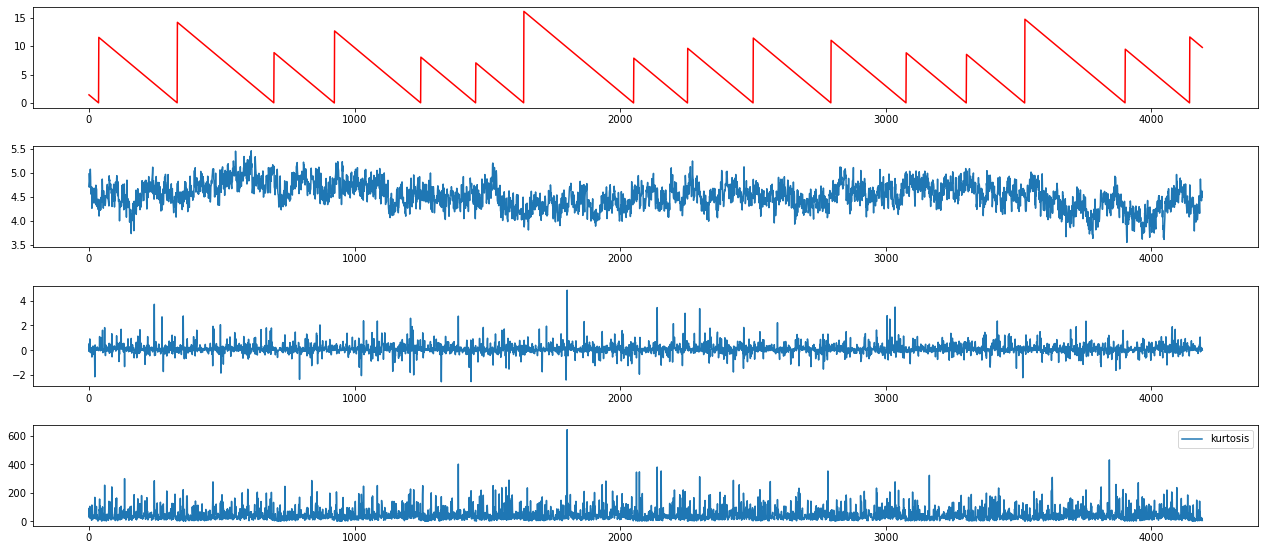

In [25]:
# YOUR CODE HERE
fig, ax = plt.subplots(4, 1, figsize=(18, 8))
ax[0].plot(y,c='r',label='Time to failure')
ax[1].plot(X.meanA,label='mean')
ax[2].plot(X.skewA,label='skewness')
ax[3].plot(X.kurtA,label='kurtosis')
plt.legend()
#... several lines of code
fig.tight_layout(pad = 2);


### 2.2. Random forest training & prediction

Rouet-Leduc et al. (2017) obtained $R^2 = 0.89$ for their RF model compared to $R^2 = 0.3$ for a naive model based on event periodicity, which means that their RF model explained 89% of the data variance. No mean absolute error (MAE) was given in the paper, which hampers direct comparison with the Kaggle competition leaderboard. Since the experiment analyzed here exhibits a very aperiodic and more realistic behavior compared to the data studied in Rouet-Leduc et al. (2017), we can expect a much lower $R^2$. We cannot direclty compare with the Kaggle competition either since the final results were estimated against a blind test set. To give an idea of the best MAE estimates on the Kaggle leaderboard, we have there MAE > 2.

**EXERCISE 7:** Split the data into training set and test set (60-40% split). Define a Random Forest regressor `model_RF` using ` RandomForestRegressor` (see hyperparameter list in first code cell of section 2). Then fit, predict and estimate the $MAE$ and $R^2$ metrics with `mean_absolute_error()` and `r2_score()` respectively.

In [37]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42,test_size = .4)
X_train.shape,X_test.shape

((2516, 64), (1678, 64))

In [26]:
model_RF = RandomForestRegressor(n_estimators = 1000,     # number of trees in the forest
                                 criterion = 'squared_error',           # quality of split measure
                                 max_features = .4,)
                                #min_samples_split=30,
                                #min_samples_leaf=30)     # nb. of features to consider for best split

In [27]:
model_RF.fit(X_train,y_train.squeeze())

RandomForestRegressor(max_features=0.4, n_estimators=1000)

In [374]:
# 7 features
y_pred=model_RF.predict(X_test)
R2=r2_score(y_test,model_RF.predict(X_test))
print('Mean abslute error:',mean_absolute_error(y_test,model_RF.predict(X_test)))
print('R-squared:',R2)

Mean abslute error: 2.2502679569827433
R-squared: 0.3915341765268454


In [385]:
#Add Percentiles
y_pred=model_RF.predict(X_test)
R2=r2_score(y_test,model_RF.predict(X_test))
print('Mean abslute error:',mean_absolute_error(y_test,model_RF.predict(X_test)))
print('R-squared:',R2)

Mean abslute error: 2.141932058562557
R-squared: 0.44353826921970674


In [38]:
#Add Threshold features
y_pred=model_RF.predict(X_test)
R2=r2_score(y_test,model_RF.predict(X_test))
print('Mean abslute error:',mean_absolute_error(y_test,model_RF.predict(X_test)))
print('R-squared:',R2)

Mean abslute error: 0.21454416965909248
R-squared: 0.9846031072314659


In [249]:
#Add Rolling features
y_pred=model_RF.predict(X_test)
R2=r2_score(y_test,model_RF.predict(X_test))
print('Mean abslute error:',mean_absolute_error(y_test,model_RF.predict(X_test)))
print('R-squared:',R2)

Mean abslute error: 2.0810522349342655
R-squared: 0.47637471434751943


The following code then plots the result, how predictions and observations compare in a scatter plot and in a time series.

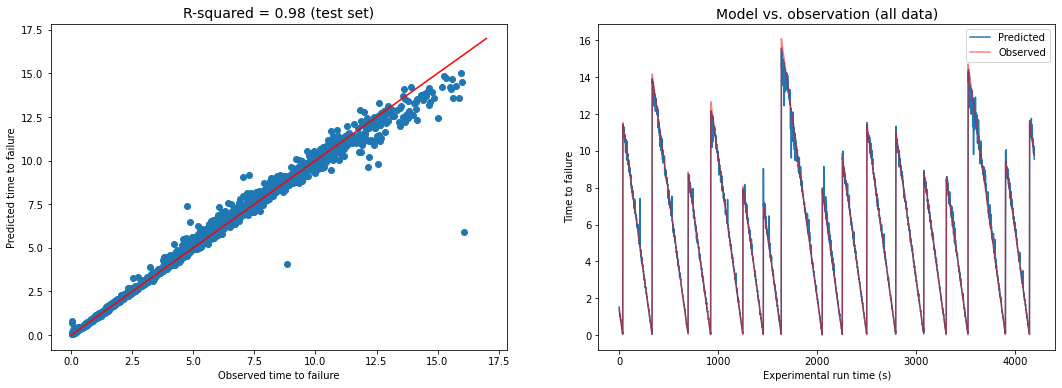

In [40]:
# not shuffled
y_timeseries_pred = model_RF.predict(X)

fig, ax = plt.subplots(1, 2, figsize=(18, 6))
ax[0].scatter(y_test, y_pred)
ax[0].plot([0,17], [0,17], 'r')
ax[0].set_xlabel('Observed time to failure')
ax[0].set_ylabel('Predicted time to failure')
ax[0].set_title('R-squared = {:.2f} (test set)'.format(R2), size = 14)

ax[1].plot(y_timeseries_pred, label = 'Predicted')
ax[1].plot(y, 'r', label = 'Observed',alpha=.5)
ax[1].set_xlabel('Experimental run time (s)')
ax[1].set_ylabel('Time to failure')
ax[1].legend()
ax[1].set_title('Model vs. observation (all data)', size = 14);

**EXERCISE 8:** Write down your remarks on performance  
Remarks based on 7(mean,(normalize/nonnormalize)var,skew,kurt) features  
Mean abslute error: 2.2502679569827433  
R-squared: 0.3915341765268454  

**EXERCISE 9:** Rerun the previous cells after defining additional features based on percentiles. Write down your remarks on performance  
Mean abslute error: 2.141932058562557  
R-squared: 0.44353826921970674  

**EXERCISE 10:** Rerun the previous cells after defining additional features based on thresholds f_0 and minimum/maximum. Write down your remarks on performance   
Mean abslute error: 0.21454416965909248  
R-squared: 0.9846031072314659

**EXERCISE 11:** BONUS: Define any other features you think may improve model performance.  
Add rolling mean and rolling std features (without thresholds)  
Mean abslute error: 2.0769144539340703  
R-squared: 0.4781857352973875  

**EXERCISE 12:** Try using another decision tree method learned previously in the chapter. Can the performance be improved? _Hint:_ `AdaBoost` has a regression version called `AdaBoostRegressor` for instance. Same with `lightgbm.LGBMClassifier` and `lightgbm.LGBMRegressor`...

## Using AdaBoostRegressor

In [30]:
from sklearn.ensemble import AdaBoostRegressor

In [58]:
model_Ada=AdaBoostRegressor(n_estimators=1000,learning_rate=0.01,random_state=10)

In [59]:
model_Ada.fit(X_train,y_train.squeeze())

AdaBoostRegressor(learning_rate=0.01, n_estimators=1000, random_state=10)

In [60]:
y_pred=model_Ada.predict(X_test)
R2=r2_score(y_test,y_pred)
print('Mean abslute error:',mean_absolute_error(y_test,y_pred))
print('R-squared:',R2)

Mean abslute error: 0.8527114446598884
R-squared: 0.9080608008934089


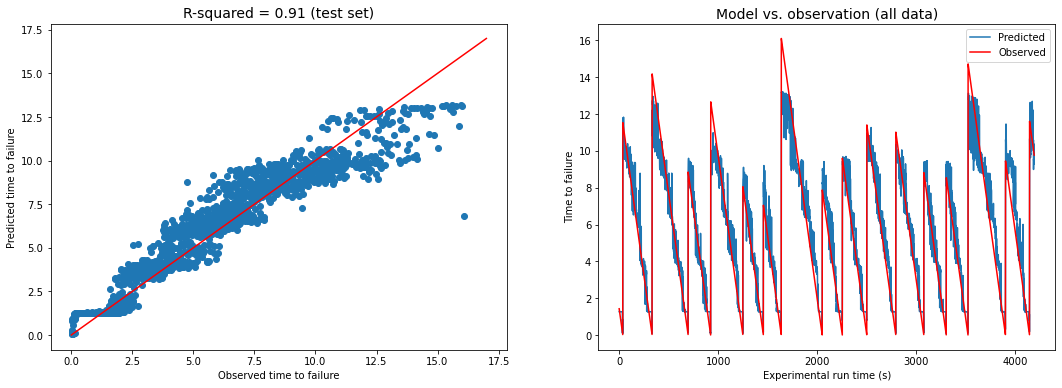

In [61]:
# not shuffled
y_timeseries_pred = model_Ada.predict(X)

fig, ax = plt.subplots(1, 2, figsize=(18, 6))
ax[0].scatter(y_test, y_pred)
ax[0].plot([0,17], [0,17], 'r')
ax[0].set_xlabel('Observed time to failure')
ax[0].set_ylabel('Predicted time to failure')
ax[0].set_title('R-squared = {:.2f} (test set)'.format(R2), size = 14)

ax[1].plot(y_timeseries_pred, label = 'Predicted')
ax[1].plot(y, 'r', label = 'Observed')
ax[1].set_xlabel('Experimental run time (s)')
ax[1].set_ylabel('Time to failure')
ax[1].legend()
ax[1].set_title('Model vs. observation (all data)', size = 14);

## Using LGBMRegressor

In [41]:
import lightgbm as lgb

In [42]:
model_lgb=lgb.LGBMRegressor(n_estimators=1000,learning_rate=0.005,min_child_weight=150,random_state=10)

In [43]:
model_lgb.fit(X_train.values,y_train.values.squeeze())

LGBMRegressor(learning_rate=0.005, min_child_weight=150, n_estimators=1000,
              random_state=10)

In [44]:
y_pred=model_lgb.predict(X_test)
R2=r2_score(y_test,y_pred)
print('Mean abslute error:',mean_absolute_error(y_test,y_pred))
print('R-squared:',R2)

Mean abslute error: 0.3489936566020302
R-squared: 0.9640454350836039


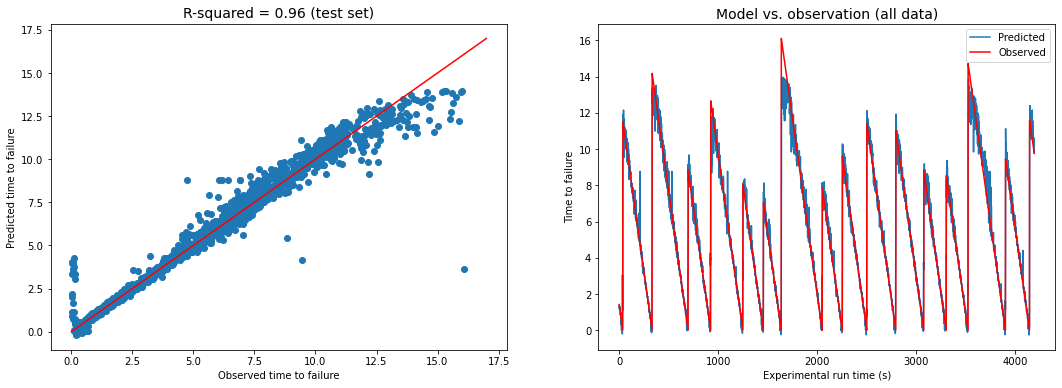

In [45]:
# not shuffled
y_timeseries_pred = model_lgb.predict(X)

fig, ax = plt.subplots(1, 2, figsize=(18, 6))
ax[0].scatter(y_test, y_pred)
ax[0].plot([0,17], [0,17], 'r')
ax[0].set_xlabel('Observed time to failure')
ax[0].set_ylabel('Predicted time to failure')
ax[0].set_title('R-squared = {:.2f} (test set)'.format(R2), size = 14)

ax[1].plot(y_timeseries_pred, label = 'Predicted')
ax[1].plot(y, 'r', label = 'Observed')
ax[1].set_xlabel('Experimental run time (s)')
ax[1].set_ylabel('Time to failure')
ax[1].legend()
ax[1].set_title('Model vs. observation (all data)', size = 14);

### 2.3 References

* Rouet-Leduc et al. (2017), Machine Learning Predicts Laboratory Earthquakes, Geophys. Res. Lett., 44, 9276-9282
* Rouet-Leducet al. (2018), Estimating fault friction from seismic signals in the laboratory, Geophys. Res. Lett., 45, 1321–1329
* Hulbert et al. (2019), Similarity of fast and slow earthquakes illuminated by machine learning. Nature Geoscience, 12, 69-74
* Rouet-Leduc et al. (2019), Continuous chatter of the Cascadia subduction zone revealed by machine learning, Nature Geoscience, 12, 75-79